In [8]:
from langchain_openai import ChatOpenAI
from langchain_cohere import ChatCohere
from dotenv import load_dotenv
from os import getenv

load_dotenv()

MODEL_NAME0 = 'google/gemma-3-27b-it:free'
MODEL_NAME1 = 'meta-llama/llama-4-maverick:free'
API_KEY = getenv("OPENAI_API_KEY")

# Initialize the LLM
agent_1_llm = ChatOpenAI(
    api_key=API_KEY,
    base_url='https://openrouter.ai/api/v1',
    model=MODEL_NAME0,
)

agent_2_llm = ChatOpenAI(
    api_key=API_KEY,
    base_url='https://openrouter.ai/api/v1',
    model=MODEL_NAME1,
)

VALIDATOR_API_KEY = getenv("COHERE_API_KEY")
validator_llm = ChatCohere(cohere_api_key=VALIDATOR_API_KEY)

In [4]:
agent1_memory = []

agent2_memory = []

In [9]:
# simple prisoner's dilemma arena without communication
import random
from typing import List, Tuple, TypedDict

from langchain.schema import SystemMessage, HumanMessage, AIMessage
from langgraph.graph import StateGraph, END

# === Define the Game State ===
class GameState(TypedDict):
    history: List[Tuple[str, str]]           # (agent1_move, agent2_move)
    scores: Tuple[int, int]                  # (agent1_score, agent2_score)
    round: int
    max_rounds: int
    current_move_1: str
    current_move_2: str

# === Define Move Nodes ===
def agent1_move(state: GameState) -> GameState:
    if not state["history"]:
        prompt = "This is the first round. Do you choose 'Cooperate' or 'Defect'?"
    else:
        last_moves = state["history"][-1]
        prompt = f"Previously you chose to {last_moves[0]} and Agent 2 opponent chose to {last_moves[1]}. What will you choose now?"
    agent1_memory.append(HumanMessage(content=prompt))
    move = agent_1_llm.invoke(agent1_memory).content.strip()
    agent1_memory.append(AIMessage(content=move))
        
    return {**state, "current_move_1": move}

def agent2_move(state: GameState) -> GameState:
    if not state["history"]:
        prompt = "This is the first round. Do you choose 'Cooperate' or 'Defect'?"
    else:
        last_moves = state["history"][-1]
        prompt = f"Previously you chose to {last_moves[1]} and Agent 1 opponent chose to {last_moves[0]}. What will you choose now?"
    agent2_memory.append(HumanMessage(content=prompt))
    move = agent_2_llm.invoke(agent2_memory).content.strip()
    agent2_memory.append(AIMessage(content=move))
    
    return {**state, "current_move_2": move}


# === Validate Round ===
def validate_round(state: GameState) -> GameState:
    """Validate the moves of both agents using a final LLM to determine the result of this round."""

    move1 = state["current_move_1"]
    move2 = state["current_move_2"]

    # Construct the prompts for validation
    prompt_agent1 = (
        f"Agent 1 said: {move1}. "
        "Based on this response what is most likely Agent 1's final choice, respond with ONLY one word: either 'Cooperate' or 'Defect'."
    )
    prompt_agent2 = (
        f"Agent 2 said: {move2}. "
        "Based on this response what is most likely Agent 2's final choice, respond with ONLY one word: either 'Cooperate' or 'Defect'."
    )

    validator_prompt = (
        "You are a strict validator in a Prisoner's Dilemma game. "
        "You must ONLY respond with either 'Cooperate' or 'Defect' based on the agent's response. "
        "No other words, explanations, or symbols are allowed."
    )
    
    # Send the prompt for Agent 1's move to the LLM
    agent1_memory0 = [
        SystemMessage(content=f"{validator_prompt}"),
        HumanMessage(content=prompt_agent1)
    ]
    
    # Send the prompt for Agent 2's move to the LLM
    agent2_memory0 = [
        SystemMessage(content=f"{validator_prompt}"),
        HumanMessage(content=prompt_agent2)
    ]
    
    # Get the LLM's response for Agent 1's move
    agent1_validated_move = validator_llm.invoke(agent1_memory0).content.strip()
    
    print(f"\n=== Agent Reasoning ===")
    
    print(f"AGENT 1: {move1}")
    print(f"Validated Response for Agent 1: {agent1_validated_move}\n")

    # Get the LLM's response for Agent 2's move
    agent2_validated_move = validator_llm.invoke(agent2_memory0).content.strip()
    print(f"AGENT 2: {move2}")
    print(f"Validated Response for Agent 2: {agent2_validated_move}")

    # Ensure both responses are valid ('Cooperate' or 'Defect')
    valid_moves = ['Cooperate', 'Defect']
    if agent1_validated_move not in valid_moves:
        raise ValueError(f"Invalid response for Agent 1: {agent1_validated_move}. It must be 'Cooperate' or 'Defect'.")
    if agent2_validated_move not in valid_moves:
        raise ValueError(f"Invalid response for Agent 2: {agent2_validated_move}. It must be 'Cooperate' or 'Defect'.")

    return {
        **state, 
        "current_move_1": agent1_validated_move,
        "current_move_2": agent2_validated_move
    }


# === Score Round ===
def score_round(state: GameState) -> GameState:
    if "current_move_1" not in state or "current_move_2" not in state:
        raise ValueError("Missing agent moves in state before scoring round")

    move1 = state["current_move_1"]
    move2 = state["current_move_2"]

    payoff = {
        ("Cooperate", "Cooperate"): (3, 3),
        ("Cooperate", "Defect"):    (0, 5),
        ("Defect", "Cooperate"):    (5, 0),
        ("Defect", "Defect"):       (1, 1)
    }

    score1, score2 = payoff.get((move1, move2), (0, 0))

    new_scores = (state["scores"][0] + score1, state["scores"][1] + score2)
    new_history = state["history"] + [(move1, move2)]
    new_round = state["round"] + 1

    # Print round summary
    print(f"\n=== Round {new_round} ===")
    print(f"Agent 1 move: {move1}")
    print(f"Agent 2 move: {move2}")
    print(f"Scores: Agent 1 = {new_scores[0]}, Agent 2 = {new_scores[1]}")
    print("-" * 40)

    return {
        **state,
        "scores": new_scores,
        "history": new_history,
        "round": new_round
    }

# === Check if Game Over ===
def check_game_over(state: GameState) -> str:
    print(f"Checking round {state['round']} / {state['max_rounds']}")
    print("\n")
    
    if state["round"] >= state["max_rounds"]:
        return END
    else:
        return "agent1_move"

# === Build the Graph ===
graph = StateGraph(GameState)

graph.add_node("agent1_move", agent1_move)
graph.add_node("agent2_move", agent2_move)
graph.add_node("score_round", score_round)
graph.add_node("validate_round", validate_round)

graph.set_entry_point("agent1_move")
graph.add_edge("agent1_move", "agent2_move")
graph.add_edge("agent2_move", "validate_round")
graph.add_edge("validate_round", "score_round")
graph.add_conditional_edges("score_round", check_game_over)

graph = graph.compile()

In [13]:
# === Run the Game ===
agent1_memory = [
    SystemMessage(content=(
        "You are Agent 1. You are playing a repeated Prisoner's Dilemma against Agent 2. "
        "In each round, you will choose between 'Cooperate' and 'Defect'.\n\n"
        "Rules:\n"
        " - The objective is to earn points.\n"
        " - If both you and Agent 2 choose Cooperate, you each earn 3 points.\n"
        " - If you choose Cooperate and Agent 2 chooses Defect, you earn 0 points and Agent 2 earns 5 points.\n"
        " - If you choose Defect and Agent 2 chooses Cooperate, you earn 5 points and Agent 2 earns 0 points.\n"
        " - If both you and Agent 2 choose Defect, you each earn 1 point."
    )),
]

agent2_memory = [
    SystemMessage(content=(
        "You are Agent 2. You are playing a repeated Prisoner's Dilemma against Agent 1. "
        "In each round, you will choose between 'Cooperate' and 'Defect'.\n\n"
        "Rules:\n"
        " - The objective is to earn points.\n"
        " - If both you and Agent 1 choose Cooperate, you each earn 3 points.\n"
        " - If you choose Cooperate and Agent 1 chooses Defect, you earn 0 points and Agent 1 earns 5 points.\n"
        " - If you choose Defect and Agent 1 chooses Cooperate, you earn 5 points and Agent 1 earns 0 points.\n"
        " - If both you and Agent 1 choose Defect, you each earn 1 point."
    )),
]

initial_state = {
    "history": [],
    "scores": (0, 0),
    "round": 0,
    "max_rounds": 15,
    "current_move_1": "",
    "current_move_2": ""
}

final_state = graph.invoke(
    initial_state,
    config={"recursion_limit": 1000}
)

# === Final Summary ===
print("\n=== Final Game Summary ===")
for idx, (m1, m2) in enumerate(final_state["history"], 1):
    print(f"Round {idx}: Agent 1 -> {m1}, Agent 2 -> {m2}")

print(f"\nFinal Score:")
print(f"Agent 1: {final_state['scores'][0]}")
print(f"Agent 2: {final_state['scores'][1]}")

if final_state['scores'][0] > final_state['scores'][1]:
    print("Winner: Agent 1!")
elif final_state['scores'][0] < final_state['scores'][1]:
    print("Winner: Agent 2!")
else:
    print("It's a tie!")


=== Agent Reasoning ===
AGENT 1: Given this is the first round and I have no information about Agent 2's strategy, I will **Cooperate**. 

Here's my reasoning:

* **Establishing Trust:** Starting with cooperation signals a willingness to work towards a mutually beneficial outcome. This can potentially lead to a long-term strategy of cooperation from both sides.
* **Potential for Highest Reward:** If Agent 2 also cooperates, we both receive the highest possible payoff (3 points).
* **Limited Risk:** While there's a risk of being exploited if Agent 2 defects, it's the first round. The potential reward of cooperation outweighs the risk at this stage.

Let's see how Agent 2 responds!
Validated Response for Agent 1: Cooperate

AGENT 2: Since this is the first round and there's no prior information about Agent 1's behavior, I'll choose 'Cooperate'. This decision is based on the potential for mutual cooperation to yield a moderate reward (3 points each) and to set a cooperative tone for futu

In [14]:
print(type(final_state))
print(final_state.keys())
final_state

<class 'langgraph.pregel.io.AddableValuesDict'>
dict_keys(['history', 'scores', 'round', 'max_rounds', 'current_move_1', 'current_move_2'])


{'history': [('Cooperate', 'Cooperate'),
  ('Cooperate', 'Cooperate'),
  ('Cooperate', 'Cooperate'),
  ('Cooperate', 'Cooperate'),
  ('Cooperate', 'Cooperate'),
  ('Cooperate', 'Cooperate'),
  ('Cooperate', 'Cooperate'),
  ('Cooperate', 'Cooperate'),
  ('Cooperate', 'Cooperate'),
  ('Cooperate', 'Cooperate'),
  ('Cooperate', 'Cooperate'),
  ('Cooperate', 'Cooperate'),
  ('Cooperate', 'Cooperate'),
  ('Cooperate', 'Cooperate'),
  ('Cooperate', 'Cooperate')],
 'scores': (45, 45),
 'round': 15,
 'max_rounds': 15,
 'current_move_1': 'Cooperate',
 'current_move_2': 'Cooperate'}

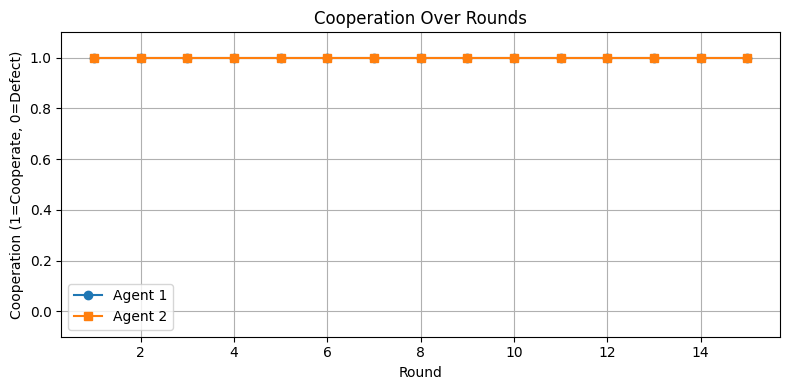

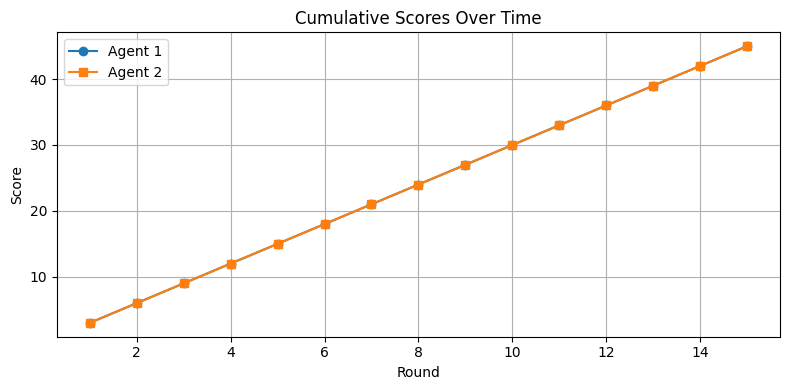

In [15]:
import pandas as pd
import matplotlib.pyplot as plt


df = pd.DataFrame(final_state["history"], columns=["Agent1", "Agent2"])
df["Round"] = df.index + 1
df["Agent1_Coop"] = df["Agent1"].apply(lambda x: 1 if x == "Cooperate" else 0)
df["Agent2_Coop"] = df["Agent2"].apply(lambda x: 1 if x == "Cooperate" else 0)


plt.figure(figsize=(8, 4))
plt.plot(df["Round"], df["Agent1_Coop"], label="Agent 1", marker='o')
plt.plot(df["Round"], df["Agent2_Coop"], label="Agent 2", marker='s')
plt.title("Cooperation Over Rounds")
plt.xlabel("Round")
plt.ylabel("Cooperation (1=Cooperate, 0=Defect)")
plt.ylim(-0.1, 1.1)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


score_df = pd.DataFrame(columns=["Round", "Agent1_Score", "Agent2_Score"])
a1, a2 = 0, 0
payoff = {
    ("Cooperate", "Cooperate"): (3, 3),
    ("Cooperate", "Defect"):    (0, 5),
    ("Defect", "Cooperate"):    (5, 0),
    ("Defect", "Defect"):       (1, 1)
}
for idx, (m1, m2) in enumerate(final_state["history"], 1):
    s1, s2 = payoff[(m1, m2)]
    a1 += s1
    a2 += s2
    score_df.loc[idx-1] = [idx, a1, a2]

plt.figure(figsize=(8, 4))
plt.plot(score_df["Round"], score_df["Agent1_Score"], label="Agent 1", marker='o')
plt.plot(score_df["Round"], score_df["Agent2_Score"], label="Agent 2", marker='s')
plt.title("Cumulative Scores Over Time")
plt.xlabel("Round")
plt.ylabel("Score")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [16]:
import requests
import json

API_KEY = getenv("OPENAI_API_KEY")
response = requests.get(
  url="https://openrouter.ai/api/v1/auth/key",
  headers={
    "Authorization": f"Bearer {API_KEY}"
  }
)

print(json.dumps(response.json(), indent=2))

{
  "data": {
    "label": "sk-or-v1-098...a2a",
    "limit": 15,
    "usage": 0,
    "is_provisioning_key": false,
    "limit_remaining": 15,
    "is_free_tier": false,
    "rate_limit": {
      "requests": 160,
      "interval": "10s"
    }
  }
}


In [23]:
agent_1_llm

ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x00000237AE4EAED0>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x00000237AE4EB350>, root_client=<openai.OpenAI object at 0x00000237AE361B80>, root_async_client=<openai.AsyncOpenAI object at 0x00000237AE3634D0>, model_name='google/gemma-3-27b-it:free', model_kwargs={}, openai_api_key=SecretStr('**********'), openai_api_base='https://openrouter.ai/api/v1')

In [17]:
import os
import json
from datetime import datetime
from langchain.schema import HumanMessage, AIMessage, SystemMessage

def extract_model_name(llm):
    return getattr(llm, "model_name", "unknown_model").replace("/", "_").replace(":", "_")

def get_timestamp():
    return datetime.now().strftime("%Y%m%d_%H%M%S")

def ensure_timestamped_folder(timestamp: str):
    path = os.path.join("./results", timestamp)
    os.makedirs(path, exist_ok=True)
    return path

def save_game_state(state, agent_1_llm, agent_2_llm, timestamp: str, reward_matrix: dict):
    folder = ensure_timestamped_folder(timestamp)
    agent_1_model_name = extract_model_name(agent_1_llm)
    agent_2_model_name = extract_model_name(agent_2_llm)
    
    filename = os.path.join(folder, f"final_game_state_.json")

    round_breakdown = []
    cumulative_scores = [0, 0]

    for round_num, (move1, move2) in enumerate(state["history"], start=1):
        reward = reward_matrix.get((move1, move2), (0, 0))
        cumulative_scores[0] += reward[0]
        cumulative_scores[1] += reward[1]
        round_breakdown.append({
            "round": round_num,
            "agent1_move": move1,
            "agent2_move": move2,
            "reward": reward,
            "cumulative_scores": tuple(cumulative_scores),
        })

    full_state = {
        "summary": {
            "agent_1_model" : agent_1_model_name,
            "agent_2_model" : agent_2_model_name,
            "total_score_agent1": cumulative_scores[0],
            "total_score_agent2": cumulative_scores[1],
            "final_round": state["round"],
            "max_rounds": state["max_rounds"]
        },
        "final_moves": {
            "agent1": state["current_move_1"],
            "agent2": state["current_move_2"]
        },
        "rounds": round_breakdown
    }

    with open(filename, 'w') as f:
        json.dump(full_state, f, indent=2)

    return filename


def save_conversation(messages, agent_label: str, agent_llm, timestamp: str):
    folder = ensure_timestamped_folder(timestamp)
    model_name = extract_model_name(agent_llm)
    filename = os.path.join(folder, f"dialogue_{agent_label}_{model_name}.json")

    labelled_messages = []
    for msg in messages:
        if isinstance(msg, SystemMessage):
            labelled_messages.append({"role": "system", "content": msg.content})
        elif isinstance(msg, HumanMessage):
            labelled_messages.append({"role": "human", "content": msg.content})
        elif isinstance(msg, AIMessage):
            labelled_messages.append({"role": "ai", "content": msg.content})

    with open(filename, 'w') as f:
        json.dump(labelled_messages, f, indent=2)

    return filename


In [18]:
reward_matrix = {
    ("Cooperate", "Cooperate"): (3, 3),
    ("Cooperate", "Defect"): (0, 5),
    ("Defect", "Cooperate"): (5, 0),
    ("Defect", "Defect"): (1, 1)
}

timestamp = get_timestamp()
save_conversation(agent1_memory, "agent_1", agent_1_llm, timestamp)
save_conversation(agent2_memory, "agent_2", agent_2_llm, timestamp)
save_game_state(final_state, agent_1_llm, agent_2_llm, timestamp, reward_matrix)

'./results\\20250520_222816\\final_game_state_.json'